In [1]:
import glob

import librosa
from librosa import display
from IPython.display import Audio

from fastai_audio.audio import (
    Path,
    SpectrogramConfig,
    AudioItem,
    AudioConfig,
    AudioList,
    audio_learner,
    audio_predict,
    ClassificationInterpretation,
)

from fastai.vision import load_learner

import numpy as np
import torch

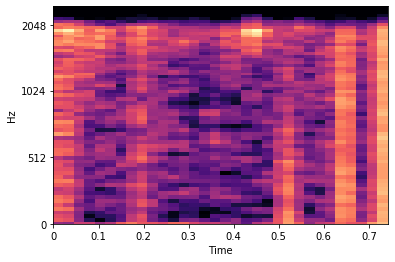

In [2]:
import glob
    
file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

y, sr = librosa.load(
    "./output/damselfish/30.wav",
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

#sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

In [3]:
path = Path("output/")

#sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=1024, hop_length=256, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
#db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-04, top_db=40.0)
#librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

sg_cfg = SpectrogramConfig(n_fft=2560, hop_length=256, n_mels=192, top_db=60, f_max=2500)

config = AudioConfig(
    use_spectro=True,
    sg_cfg=sg_cfg,
    duration=1000
)

#label_pattern = r'_([mf]\d+)_'
al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
#al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_const("damselfish")

In [5]:
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
tfms = None
db = al.transform(tfms).databunch(bs=64)
db.show_batch(rows=10)

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 0.67 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 0.78 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 0.8 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/199.wav
Total Length: 0.63 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/162.wav
Total Length: 0.71 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/124.wav


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


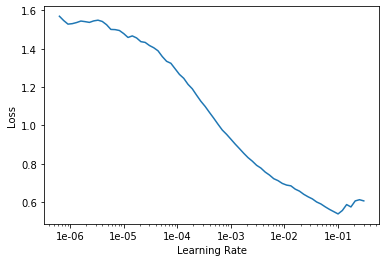

In [19]:
learn = audio_learner(db)

#learn = cnn_learner(db, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

#learn = cnn_learner(db, models.densenet161, metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(30, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.000781,0.263614,0.939024,00:01
1,0.000872,0.281296,0.963415,00:01
2,0.002469,0.311049,0.951219,00:01
3,0.001777,0.172432,0.963415,00:01
4,0.001362,0.251167,0.951219,00:01
5,0.001157,0.326922,0.951219,00:01
6,0.001080,0.326332,0.951219,00:01
7,0.000921,0.610399,0.926829,00:01
8,0.000775,0.271473,0.975610,00:01
9,0.002543,0.347597,0.951219,00:01


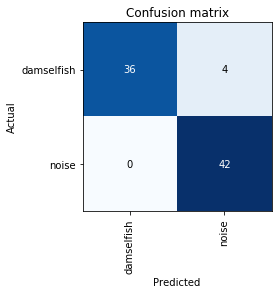

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
#learn.save("/workspaces/sonumator/stage1")
learn.unfreeze()

learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.fit_one_cycle(3, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.000234,0.279337,0.963415,00:01
1,0.000119,0.405879,0.926829,00:01
2,0.000176,0.365041,0.951219,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [23]:
learn.save('/workspaces/sonumator/stage1')

In [6]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage1")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

(Category noise, tensor(1), tensor([0.0026, 0.9974]))

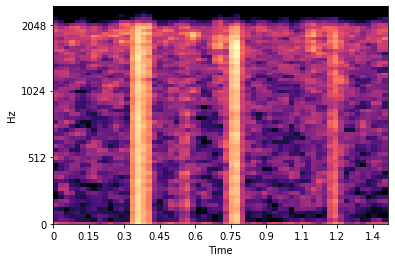

In [23]:
newsample_path = "newnoise.wav"
y, sr = librosa.load(
    newsample_path,
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

item = AudioItem(path=newsample_path)
al = AudioList([item], path=item.path, config=learn.data.x.config)
ai = AudioList.open(al, item.path)
learn.predict(ai)